In [89]:
import numpy as np

# Grid parameters
nx, ny = 65, 65
dx = dy = 1 / (nx - 1)
nt = 500  # number of timesteps
dt = 0.0001  # timestep size
nu = 0.01  # viscosity
rho = 1.0  # density

# Initialize the velocity and pressure fields
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))

# Set initial conditions
# Lid-driven cavity: top boundary at y = 1 (ny-1)
u[ny-1, :] = 1.0


In [90]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx) + 
                     (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx))**2 -
                    2 * ((u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dy) *
                         (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dx)) -
                    ((v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy))**2))
    return b

def intermediate_velocity(u, v, b, dt, dx, dy, nu):
    un = u.copy()
    vn = v.copy()

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, :-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[:-2, 1:-1]) -
                     dt / (2 * rho * dx) * (b[1:-1, 2:] - b[1:-1, :-2]) +
                     nu * (dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) +
                           dt / dy**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1])))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, :-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[:-2, 1:-1]) -
                     dt / (2 * rho * dy) * (b[2:, 1:-1] - b[:-2, 1:-1]) +
                     nu * (dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) +
                           dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1])))
    return u, v


In [91]:
def poisson_pressure(p, dx, dy, b):
    pn = np.zeros_like(p)
    for _ in range(10):  # Iteration count might need to be increased for convergence
        pn[:] = p[:]
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          b[1:-1, 1:-1] * dx**2 * dy**2 / (2 * (dx**2 + dy**2)))

        # Apply boundary conditions for pressure
        # Neumann boundary condition with a derivative approximated by forward/backward difference
        p[:, -1] = p[:, -2]  # dp/dx = 0 at the right wall
        p[0, :] = p[1, :]    # dp/dy = 0 at the bottom wall
        p[:, 0] = p[:, 1]    # dp/dx = 0 at the left wall
        p[-1, :] = 0         # Dirichlet condition at the top wall (could be set to a constant if needed)

    return p


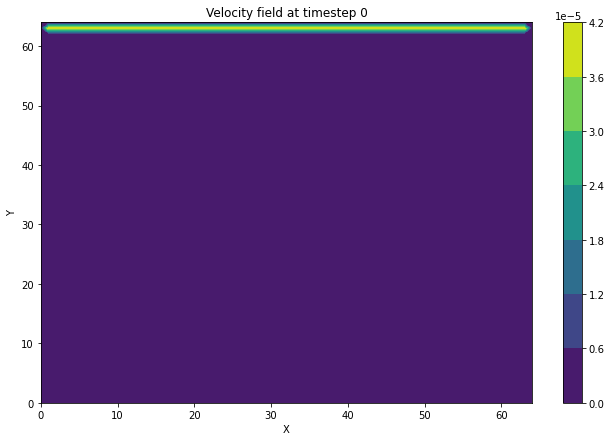

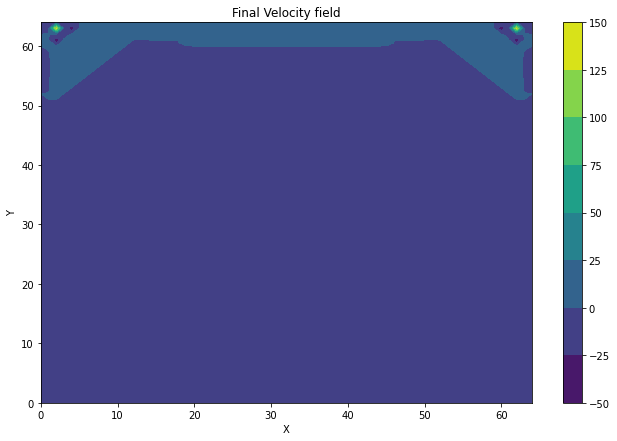

In [92]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Initialize the 'b' array which will store the divergence
b = np.zeros((ny, nx))

nt = 3
dt = 0.000001#min(dx*dx/nu/4, dy*dy/nu/4)
for n in range(nt):
    # Step 1: Build up the b array using the current velocity field
    b = build_up_b(b, rho, dt, u, v, dx, dy)
    
    # Step 2: Compute intermediate velocities
    u, v = intermediate_velocity(u, v, b, dt, dx, dy, nu)
    
    # Step 3: Solve the Poisson equation for the pressure correction
    p = poisson_pressure(p, dx, dy, b)

        # Step 4: Update velocities using the corrected pressure
    u[1:-1, 1:-1] = (u[1:-1, 1:-1] -
                     dt / rho * (p[1:-1, 2:] - p[1:-1, :-2]) / (2 * dx))
    v[1:-1, 1:-1] = (v[1:-1, 1:-1] -
                     dt / rho * (p[2:, 1:-1] - p[:-2, 1:-1]) / (2 * dy))
    
    # Boundary conditions for the velocity fields
    # u-velocity on the top wall
    u[ny-1, :] = 1  # Lid speed
    # u-velocity on the other walls
    u[0, :] = u[-1, :] = u[:, 0] = u[:, -1] = 0
    # v-velocity on all walls
    v[:, 0] = v[:, -1] = v[0, :] = v[-1, :] = 0

    # Optional: Visualization every few steps
    if n % 50 == 0:  # Adjust frequency of visualization as needed
        plt.figure(figsize=(11, 7))
        plt.contourf(u, cmap=cm.viridis)
        plt.colorbar()
        plt.title(f'Velocity field at timestep {n}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

# Final visualization
plt.figure(figsize=(11, 7))
plt.contourf(u, cmap=cm.viridis)
plt.colorbar()
plt.title('Final Velocity field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
